<a href="https://www.kaggle.com/code/candacevogel/jewelry-recognition-candace-fork?scriptVersionId=264781609" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.v2 as transforms
from torchvision import datasets 
from torchvision.transforms import ToTensor

from os import path
from PIL import Image

# This next will will load our data for us and create path to the files

In [2]:
dataset_root = '/kaggle/input/celeba-dataset'

image_path = path.join(dataset_root, 'img_align_celeba/img_align_celeba')
attributes_path = path.join(dataset_root, 'list_attr_celeba.csv')

# Reading the attributes of the pictures

In [3]:
df_attributes = pd.read_csv(attributes_path)
df_attributes.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# Changes the value from -1 to 1 to 0 to 1

In [4]:
df_attributes.replace(-1, 0, inplace = True)
df_attributes['Wearing_Necklace'].head(200)

0      0
1      0
2      0
3      1
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: Wearing_Necklace, Length: 200, dtype: int64

# Checking for how many people in the dataset have necklaces

In [5]:
df_attributes['Wearing_Necklace'].value_counts()

Wearing_Necklace
0    177686
1     24913
Name: count, dtype: int64

# Balance dataset

In [6]:
necklace_df = df_attributes[df_attributes['Wearing_Necklace'] == 1 ]
no_necklace_df = df_attributes[ df_attributes['Wearing_Necklace'] == 0]

necklace_count = len(necklace_df)

no_necklace_same_size = no_necklace_df.sample(necklace_count)

df_necklace_training = pd.concat( [necklace_df, no_necklace_same_size], axis = 0)

df_necklaces = df_necklace_training[ [ 'image_id', 'Wearing_Necklace']]
df_necklaces.sample(10)

,image_id,Wearing_Necklace
3878,003879.jpg,0
79287,079288.jpg,1
36116,036117.jpg,0
155345,155346.jpg,0
126201,126202.jpg,0
8385,008386.jpg,0
64622,064623.jpg,0
98487,098488.jpg,0
126747,126748.jpg,1
7327,007328.jpg,0


# Create dataset class

In [7]:
class CelebDataset(Dataset):
    def __init__(self, images_path, attributes_dataframe, img_transform=None, attr_transform=None):
        self.images_path = images_path
        self.attributes_dataframe = attributes_dataframe
        self.img_transform = img_transform
        self.attr_transform = attr_transform
        self.image_filename = attributes_dataframe['image_id'].tolist()

    def __getitem__(self, index):
        image_filename = self.image_filename[index]
        image_path = path.join(self.images_path, image_filename)
        img = Image.open(image_path).convert('L')

        attributes = self.attributes_dataframe.iloc[index]
        necklace = attributes.Wearing_Necklace.astype('int')

        if self.img_transform:
            img = self.img_transform(img)

        if self.attr_transform:
            necklace = self.attr_transform(necklace)

        return img, necklace

    def __len__(self):
        return len(self.attributes_dataframe)

# Define image transformations

In [8]:
image_size = 128

image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop([image_size, image_size]),
    transforms.ToTensor(),
])

dataset = CelebDataset(image_path, df_necklace_training, image_transform)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Divide dataset into training and test data

In [9]:
# 80% training 
# 20% testing
train_dataset, test_dataset = random_split(dataset, (0.8, 0.2) )

# Create dataloaders for training & testing data

In [10]:
batch_size = 32
# need to batch data to train and test in smaller chunks, data is too big
# batch for speed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# DataLoader function for sending information to our NN

# Visualize example images

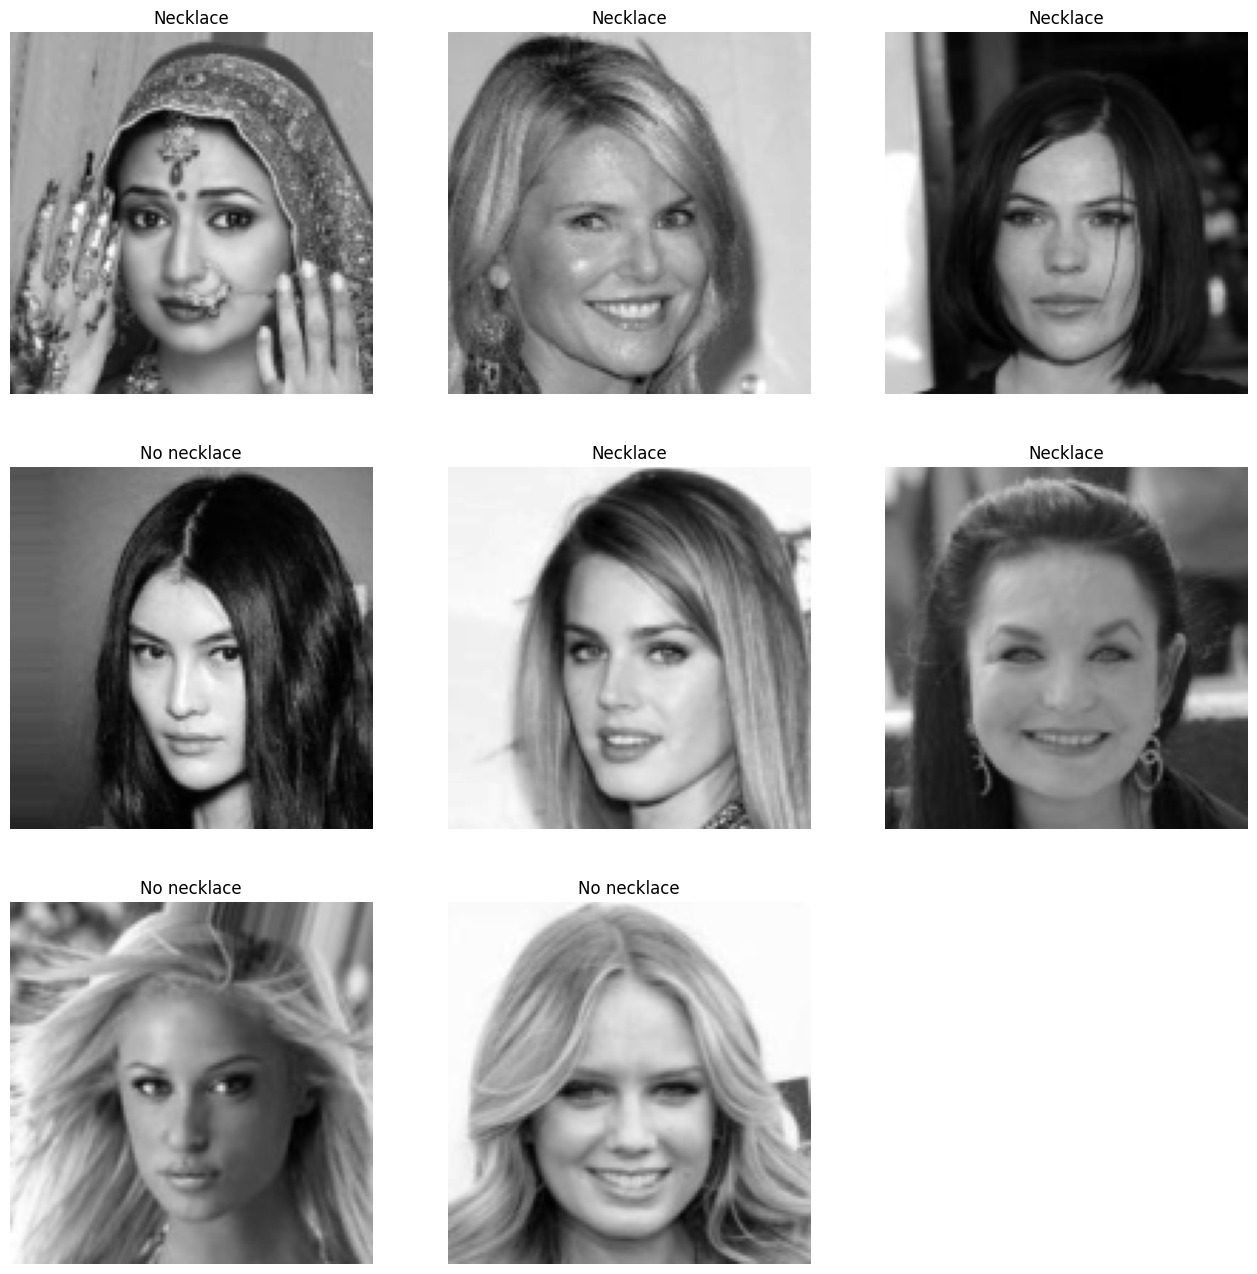

In [11]:
import matplotlib.pyplot as plt
# create map plot of data
figure = plt.figure(figsize=(16,16)) # our canvas to display data
cols = 3
rows = 3
for i in range(1, cols * rows):
    # loops over dataset
    # .randint picks random data from dataset
    sample_index = torch.randint(len(train_dataset), size=(1, )).item()
    img, label = train_dataset[sample_index]
    figure.add_subplot(rows, cols, i)
    # display titles in plots
    plt.title('Necklace' if label == 1 else 'No necklace')
    plt.axis('off')
    # display grayscale image
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()
# initialize function

# Create a device

In [12]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f'Using {device} device')
# detecting hardware to use for trianing using if/else statement
# identifies accelerator type for processing dataset

Using cuda device


# Create neural network!

In [13]:
class NeuralNetwork(nn.Module):
    # initialize all network layers
    def __init__(self):
        super().__init__() # parent class
        self.flatten = nn.Flatten() # flatten tensor to 1D
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            # flattened to 512 neurons
            nn.ReLU(), # activiation function
            nn.Linear(512, 512), # hidden layer
            nn.ReLU(),
            nn.Linear(512, 2) # output layer
        )
    def forward(self, x):
        # x is one training data item aka one image
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # logits = values from each output neuron

model = NeuralNetwork().to(device)
# creates instance of NN model and .to() chooses appropriate hardware

model #print model for user

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

# Define backwards pass

In [14]:
loss_function = nn.CrossEntropyLoss()
# classification function - how wrong is our model predictions?
# CrossEntropyLoss is for categorical predictions 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# optimizer will improve our dataset predictions...
# by updating weights and gradients

# Define training function

In [15]:

def train(dataloader, model, loss_function, optimizer):
    # len() prints size of dataset
    size = len(dataloader.dataset)
    model.train() # training mode for NN model
    # working with batched data
    for batch_num, (image_batch, label_batch) in enumerate(dataloader):
        img, labels = image_batch.to(device), label_batch.to(device)
        # hardware function
        predictions = model(img) # forward pass
        loss = loss_function(predictions, labels) # how wrong is our model?
        loss.backward() # calculate the changes that will be made to weights and biases
        optimizer.step()  # apply changes
        optimizer.zero_grad() # resets optimizer in between batches
        # if batch number is divisble by 100..
        if batch_num % 100 == 0: # for every 100th batch...
            loss = loss.item() # loss value 
            current = (batch_num + 1) * len(img) # calculate batched samples
            print(f'Loss: {loss} [ { current } / {size} ]') #prints data for user

# Define test function

In [16]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # model in test mode
    test_loss = 0 # by how much is our data wrong?
    test_correct = 0 # track accuracy rate

    with torch.no_grad(): # don't change the model
        # loop over batches in test data
        for image_batch, label_batch in dataloader:
            img, labels = image_batch.to(device), label_batch.to(device) #hardware function
            predictions = model(img)  #forward pass
            test_loss = loss_function(predictions, labels).item() #how wrong is our data?
            test_correct += (predictions.argmax(1) == labels).type(torch.float).sum().item()
            # count predictions ^
    test_loss /= num_batches
    # calculate the average of loss from all batches
    test_correct /= size #calculate accuracy rate

    print(f'Test results, Accuracy: {test_correct * 100}% Average Loss: {test_loss}')




# Training the model

In [17]:

#epoch = 5 # initialize epoch variable, number of training epocs
# epoch = 1
# having trouble pushing to github using 5 epoch

# loop over training epoch
#for t in range(epoch):
    #print(f'EPOCH {t+1} **********')
    #train(train_dataloader, model, loss_function, optimizer)
    #test(test_dataloader, model, loss_function)



# Test with more images

In [18]:
def predict_necklace(image_file_path):
    # this function will predict if an image shows necklace
    print(image_file_path)
    test_image = Image.open(image_file_path).convert('L')
    # convert img to grayscale
    mystery_image = image_transform(test_image)
    mystery_image = mystery_image.to(device)
    # set model to evaluate data
    model.eval()
    with torch.no_grad(): #disable gradients for yes/no
        model_output = model(mystery_image) # logits
    print(model_output)
    label = torch.argmax(model_output).item() # 0 or 1?
    # 0 means no necklace and 1 means necklace
    label_text = 'Necklace' if label == 1 else 'No necklace'
    print('Prediction: ' + label_text)

#image_1 = '/kaggle/input/necklaces/no_necklace_1.png'
#predict_necklace(image_1)

import os
# get and sort image files and construct file paths for reading files
for image_file in sorted(os.listdir('/kaggle/input/necklaces/')):
    image_file_path = path.join('/kaggle/input/necklaces/', image_file)
    predict_necklace(image_file_path)

/kaggle/input/necklaces/no_necklace_1.png
tensor([[0.0607, 0.1064]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_10.png
tensor([[0.0181, 0.0885]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_11.png
tensor([[-0.0153,  0.0789]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_12.png
tensor([[0.0460, 0.0620]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_2.png
tensor([[0.0677, 0.0457]], device='cuda:0')
Prediction: No necklace
/kaggle/input/necklaces/no_necklace_3.png
tensor([[0.0480, 0.0498]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_4.png
tensor([[0.0828, 0.0743]], device='cuda:0')
Prediction: No necklace
/kaggle/input/necklaces/no_necklace_5.png
tensor([[0.0375, 0.0748]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no_necklace_6.png
tensor([[0.0466, 0.0829]], device='cuda:0')
Prediction: Necklace
/kaggle/input/necklaces/no